In [1]:
import numpy as np
import scipy.linalg as scila
import scipy.integrate as sciint
import TransportMaps.Distributions as DIST
import TransportMaps.Distributions.Decomposable as DISTDEC
import TransportMaps.Likelihoods as LKL
import TransportMaps.Maps as MAPS
import matplotlib.pyplot as plt
%matplotlib inline

# Sequential data assimilation models

In sequential data assimilation measurements of the output of a system are continuously integrated in order to update the state description of the system. In this context the state description of the system is given in terms of probability distributions and the updates are described thorugh Bayesian posterior distributions.

The most general configuration involves the update of the prior belief on the states ${\bf Z}_\Lambda$, for time index-set $\Lambda={0,\ldots,n}$, through the assimlation of the observations ${\bf Y}_\Xi$, for $\Xi \subset \Lambda$, leading to the Bayesian formulation (see [here](pm-bayesian-inference.html)):

$$ \pi({\bf Z}_\Lambda|{\bf Y}_\Xi={\bf y}) \propto \mathcal{L}_{\bf y}({\bf Z}_\Lambda) \pi({\bf Z}_\Lambda) $$

If the system being described is a dynamical systems, then it often offers a favorable conditional independence structure which can be leveraged in the design of algorithms. The simples of these structures is the Markov property, i.e. 

$$ \pi({\bf Z}_k \vert {\bf Z}_{k-1}, \ldots, {\bf Z}_0) = \pi({\bf Z}_k\vert{\bf Z}_{k-1}) $$

This property is inherited by the following state-space representation of the system

$$ {\bf Z}_{k+1} = G({\bf Z}_k, {\bf w}_k) \;, \quad {\bf w}_k \sim \nu_{w_k} $$
$$ {\bf Y}_k = H({\bf Z}_k, {\bf v}_k) \;, \quad {\bf v}_k \sim \nu_{v_k} $$
$$ {\bf Z}_0 \sim \nu_0$$

This property, along with the fact that the observation ${\bf Y}_k$ is assumed to depend only from the state ${\bf Z}_k$, can be depicted through the follwing graphical model [[OR9]](aa-references.html#lauritzen1996)

![](./Figures/dataAssimilation.png)

Thanks to the Markov property then the Bayesian posterior factorizes:

$$ 
\pi({\bf Z}_\Lambda|{\bf Y}_\Xi={\bf y}) \propto
\left( \prod_{t\in \Xi} \mathcal{L}\left({\bf y}_t \left\vert {\bf Z}_t\right.\right) \right) 
\left( \prod_{k=1}^n \pi\left(\left.{\bf Z}_{k} \right\vert {\bf Z}_{k-1}\right) \right) 
\pi\left({\bf Z}_{0} \right)
$$

We will use the following example in order to describe how to assemble such distributions. For a more complex example involving also hyper-parameters, see the [stochastic volatility example](example-sequential-stocvol-6d.html).

### Linear Gaussian model

The following example is taken from [[OR10]](aa-references.html#brown1997) and is a simplification of the model that describes the "biases" of the gyroscopes used in inertial navigation systems. The final goal of performing data assimilation for this problem is to infer the values of the unobservable "biases" through some external position measurements. The model is of historical importance because it represented one of the first applications [[OR11]](aa-references.html#bona1966) of the Kalman's filter. Here we will solely discuss the mathematical aspects of the model to the end of constructing a simple data assimilation example.

We consider the 6-dimensional linear system of stochastic differential equations

$$
\dot{\bf z} = \underbrace{\left[\begin{array}{ccc|ccc}
0 & \Omega_z & 0 & & & \\
-\Omega_z & 0 & \Omega_x & & {\bf I} & \\
0 & -\Omega_x & 0 & & & \\
\hline
& & & & & \\
& {\bf 0} & & & {\bf 0} & \\
\\
\end{array}\right]}_{\bf F} {\bf z} 
+ \underbrace{\left[\begin{array}{ccc|ccc}
& & & & & \\
& {\bf 0} & & & {\bf 0} & \\
& & & & & \\
\hline
& & & & & \\
& {\bf 0} & & & {\bf I} & \\
\\
\end{array}\right]}_{\bf G} 
\left[\begin{array}{c}
\\ {\bf 0} \\ \\ 
\hline
\\ \varepsilon_k \\ \\
\end{array}\right]
$$

where 

$$
\Omega_x = \Omega \cos(\theta) \;,\quad \Omega_z = \Omega \sin(\theta)\\
\Omega=0.2625161\;\frac{\rm rad}{\rm hr} \;, \quad \theta=\frac{\pi}{4}\;{\rm rad} \\
\varepsilon_k \sim \mathcal{N}\left( {\bf 0}, {\bf W}\right) \;, \quad
{\bf W} = \sigma^2_\varepsilon {\bf I} \; \quad
\sigma_\varepsilon = 0.02 \frac{\pi}{180}\;\frac{\rm rad}{\rm hr} \;, \\
{\bf z}(0) \sim \mathcal{N}\left({\bf 0}, {\bf Q}_0\right) \;, \quad
{\bf Q}_0 = {\rm diag}(\sigma^0_x, \sigma^0_y, \sigma^0_z, \sigma^0_\varepsilon,\sigma^0_\varepsilon,\sigma^0_\varepsilon) \\
\sigma^0_x = \sigma^0_y = \left(\frac{1000\,{\rm m}}{r_e\,{\rm m}}\right)^2 \;, \quad
\sigma^0_z = \left( 0.1 \frac{\pi}{180} \,{\rm rad}\right)^2 
\;, \quad
\sigma^0_\varepsilon = \left( 0.02 \frac{\pi}{180} \,\frac{\rm rad}{\rm hr} \right)^2 \;,
$$

and $r_e = 6367253 \,{\rm m}$ is the radius of the earth. In the navigation application at hand ${\bf z}_{1:3}$ are west, south and up position errors, while ${\bf z}_{4:6}$ are the gyro drift rates (biases).

In [2]:
re = 6367253.
Omega = 0.2625161
theta = np.pi / 4
Ox = Omega * np.cos(theta)
Oz = Omega * np.sin(theta)
F = np.zeros((6,6))
F[0,1] = Oz; F[1,0] = -Oz; F[1,2] = Ox; F[2,1] = -Ox;
F[0,3] = F[1,4] = F[2,5] = 1.
G = np.zeros((6,6))
G[3,3] = G[4,4] = G[5,5] = 1.
sig2_eps = (0.02 * np.pi / 180)**2
W = np.eye(6) * sig2_eps
Q0 = np.zeros((6,6))
Q0[0,0] = Q0[1,1] = (1000./re)**2
Q0[2,2] = (0.1 * np.pi/180)**2
Q0[3,3] = Q0[4,4] = Q0[5,5] = sig2_eps

From the differential equation above we now derive its finite difference counterpart

$$ 
{\bf Z}_{k+1} = \Phi {\bf Z}_k + {\bf w}_k \;,
$$

for $\Delta t=0.5$, using the fact that $\Phi = \exp({\bf F} \Delta t)$ and ${\bf w}_k={\bf w}\sim\mathcal{N}(0,{\bf Q}(\Delta t,0))$ where

$$
\dot{\bf Q}(t,0) = {\bf F} {\bf Q}(t,0) + {\bf Q}(t,0) {\bf F}^\top + {\bf G} {\bf W} {\bf G}^\top \;, \quad {\bf Q}(0,0)=0
$$

In [3]:
dt = 0.5
Phi = scila.expm(F*dt)
GWG = np.dot(G, np.dot(W,G))
def f(q,t,F,GWG):
    Q = q.reshape((6,6))
    rhs = np.dot(F,Q) + np.dot(Q,F.T) + GWG
    return rhs.flatten()
q0 = np.zeros(6*6)
T = [0, dt]
sol = sciint.odeint(f, q0, T, args=(F, GWG))
Q = sol[1].reshape((6,6))

Let us now construct a sythetic trajectory of 48h from the model.

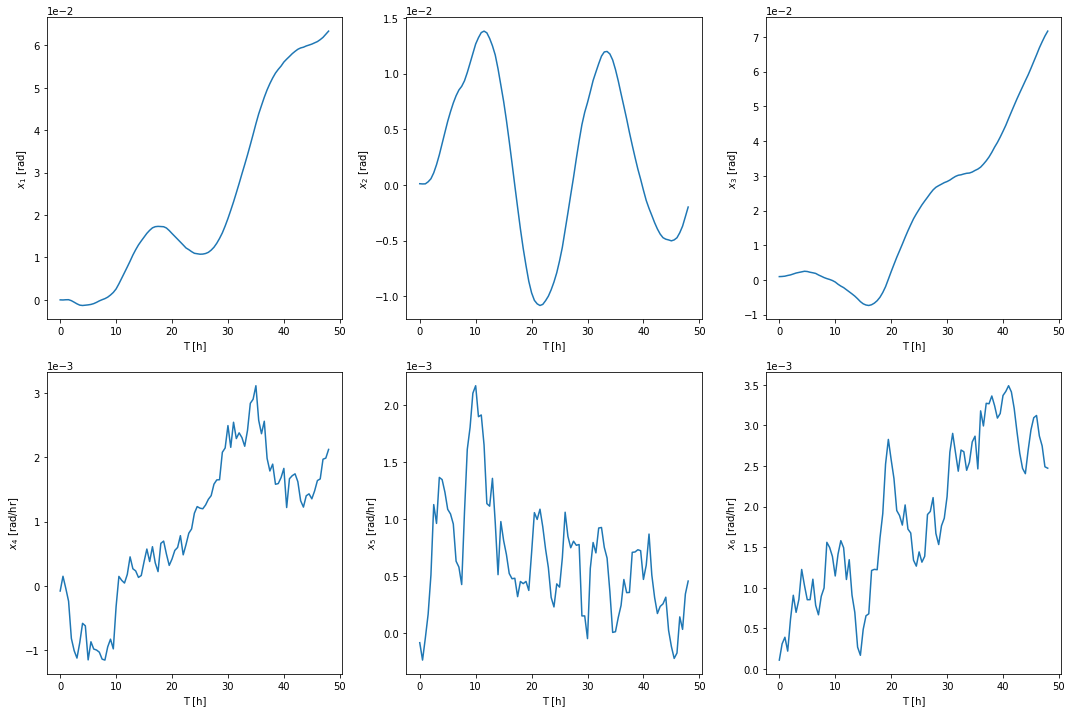

In [4]:
nu_x0 = DIST.GaussianDistribution(np.zeros(6), Q0)
nu_w = DIST.GaussianDistribution(np.zeros(6), Q)
Tf = 48
nsteps = int(round(Tf / dt))
T = np.zeros( nsteps + 1 )
Z = np.zeros( (6, nsteps+1) )
Z[:,0] = nu_x0.rvs(1)[0,:]
for i in range(nsteps):
    T[i+1] = T[i] + dt
    Z[:,i+1] = np.dot(Phi, Z[:,i]) + nu_w.rvs(1)[0,:]
plt.figure(figsize=(15,10))
plt.subplot(231); plt.plot(T,Z[0,:]); plt.ylabel("$x_1$ [rad]"); plt.xlabel("T [h]"); plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.subplot(232); plt.plot(T,Z[1,:]); plt.ylabel("$x_2$ [rad]"); plt.xlabel("T [h]"); plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.subplot(233); plt.plot(T,Z[2,:]); plt.ylabel("$x_3$ [rad]"); plt.xlabel("T [h]"); plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.subplot(234); plt.plot(T,Z[3,:]); plt.ylabel("$x_4$ [rad/hr]"); plt.xlabel("T [h]"); plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.subplot(235); plt.plot(T,Z[4,:]); plt.ylabel("$x_5$ [rad/hr]"); plt.xlabel("T [h]"); plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.subplot(236); plt.plot(T,Z[5,:]); plt.ylabel("$x_6$ [rad/hr]"); plt.xlabel("T [h]"); plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
plt.tight_layout()

We represent the obervation system through the following model:

$$ {\bf Y}_k = \underbrace{\left[\begin{array}{cccccc}
1 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 \\
1 & 0 & 1 & 0 & 0 & 0 
\end{array}\right]}_{H} {\bf Z}_k + {\bf v}_k \;, $$

where

$$ {\bf v}_k \sim \mathcal{N}\left({\bf 0}, {\bf R}\right) \;, \quad
{\bf R} = \left[\begin{array}{ccc}
\sigma_x & 0 & 0 \\
0 & \sigma_y & 0 \\
0 & 0 & \sigma_z \end{array}\right]\\
\sigma_x = \sigma_y = \left(\frac{1000\,{\rm m}}{r_e\,{\rm m}} \right)^2
\;, \quad
\sigma_z = \left(\frac{1}{60} \frac{\pi}{180} \,{\rm rad}\right)^2 \;.
$$

In [5]:
sig2_xy = (1000./re)**2
sig2_z = (1./60. * np.pi/180)**2
H = np.zeros((3,6))
H[0,0] = H[1,1] = H[2,0] = H[2,2] = 1
R = np.zeros((3,3))
R[0,0] = R[1,1] = sig2_xy
R[2,2] = sig2_z

Let us now generate some observations from the trajectory obtained above. For illustrative purposes we assume miss observations 20-28.

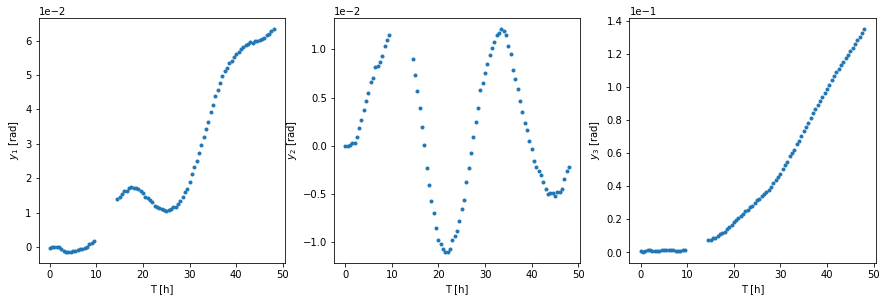

In [6]:
nu_v = DIST.GaussianDistribution(np.zeros(3), R)
Y = []
for i in range(nsteps+1):
    if i<20 or i>28:
        Y.append( np.dot(H, Z[:,i]) + nu_v.rvs(1)[0,:] )
    else:
        Y.append(None)
plt.figure(figsize=(15,4.5))
y1 = [y[0] if y is not None else None for y in Y]
plt.subplot(131); plt.plot(T,y1,'.'); plt.ylabel("$y_1$ [rad]"); plt.xlabel("T [h]"); plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
y2 = [y[1] if y is not None else None for y in Y]
plt.subplot(132); plt.plot(T,y2,'.'); plt.ylabel("$y_2$ [rad]"); plt.xlabel("T [h]"); plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
y3 = [y[2] if y is not None else None for y in Y]
plt.subplot(133); plt.plot(T,y3,'.'); plt.ylabel("$y_3$ [rad]"); plt.xlabel("T [h]"); plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));

We have now all the pieces needed to define the distribution

$$
\pi({\bf Z}_\Lambda|{\bf Y}_\Xi={\bf y}) \propto
\left( \prod_{t\in \Xi} \mathcal{L}\left({\bf y}_t \left\vert {\bf Z}_t\right.\right) \right) 
\left( \prod_{k=1}^n \pi\left(\left.{\bf Z}_{k} \right\vert {\bf Z}_{k-1}\right) \right) 
\pi\left({\bf Z}_{0} \right)
$$

associated to the state-space model

$$
{\bf Z}_{k+1} = \Phi {\bf Z}_k + {\bf w}_k \;, \quad 
{\bf Z}_0 \sim \mathcal{N}({\bf 0}, {\bf Q}_0) \;, \quad
{\bf w}_k \sim \mathcal{N}({\bf 0}, {\bf Q}) \;, \\
{\bf Y}_k = H {\bf Z}_k + {\bf v}_k \;, \quad
{\bf v}_k \sim \mathcal{N}({\bf 0},{\bf R}) \;.
$$

Let us first define the transition distributions $\pi\left({\bf Z}_{k} \middle\vert {\bf Z}_{k-1}\right)$:

In [7]:
PhiMap = MAPS.LinearMap(np.zeros(6), Phi)
pi_trans = DISTDEC.AR1TransitionDistribution(nu_w, PhiMap)

Now we define the **full posterior** by the sequential introduction of likelihoods $\mathcal{L}\left({\bf y}_t \left\vert {\bf Z}_t\right.\right)$ and transition probabilities $\pi\left(\left.{\bf Z}_{k} \right\vert {\bf Z}_{k-1}\right)$

In [8]:
pi = DISTDEC.SequentialHiddenMarkovChainDistribution([], [])
for n in range(nsteps+1):
    if Y[n] is None:
        ll = None
    else:
        Hmap = MAPS.LinearMap(np.zeros(3), H)
        ll = LKL.AdditiveLogLikelihood(Y[n], nu_v, Hmap)
    if n == 0: pin = nu_x0
    else: pin = pi_trans
    pi.append(pin, ll)

This distribution can then be characterized with a method of choice (e.g. Kalman filters/smoothers, particle filiters, transport filters/smoothers, etc.).